# Data Processing

In [1]:
import torch
from torchvision import datasets
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
from typing import Tuple, Dict, List
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
import numpy as np
import random
import pathlib
import os
import shutil

# 1. Working with torchvision datasets: FashionMNIST and CIFAR10

## 1.1. Loading an in-built PyTorch Dataset

We'll start working with common computer vision datasets:

* **FashionMNIST**, made by Zalando Research, contains grayscale images of 10 different kinds of clothing.

* The **CIFAR10** dataset is composed of color images, categorized into 10 different object classes, including animals, vehicles, and everyday objects.

PyTorch has a lot of common computer vision datasets stored in `torchvision.datasets`, including FashionMNIST in [`torchvision.datasets.FashionMNIST()`](https://pytorch.org/vision/main/generated/torchvision.datasets.FashionMNIST.html) and CIFAR10 in [`torchvision.datasets.CIFAR10()`](https://pytorch.org/vision/main/generated/torchvision.datasets.CIFAR10.html)

To download them, we have the following parameters:
* `root (str):` - The root directory where the dataset will be saved.
* `train (bool,optional):` - Specify whether you prefer the training or test split.
* `download (bool,optional):` -  If True, downloads the dataset from the internet and puts it in root directory.
* `transform (callable,optional):` - Provide the desired transformations you would like to apply to the data (images).
* `target_transform (callable,optional):` - Provide the desired transformations you would like to apply to the targets (labels).

Many other datasets in `torchvision` have these parameter options.

In [2]:
## FashionMNIST
train_data = datasets.FashionMNIST(
    root = "data",
    train = True, # get training data
    download = True,
    transform = transforms.ToTensor() # images come as PIL format, we want to turn into Torch tensors
)

test_data= datasets.FashionMNIST(
    root = "data",
    train = False, # get test data
    download = True,
    transform = transforms.ToTensor()
)

Let's check out the first sample of the training data. We can index Datasets manually like a list: train_data[index]

In [3]:
# See first training sample
image, label = train_data[0]

# Check the shape of the image.
print(f"Image shape: {image.shape}")

Image shape: torch.Size([1, 28, 28])


The image contains visual data in the form of a Torch tensors. The label is an integer value that indicates the specific class or category associated with the image. You can try to print both variables to visualize their content.  

>The shape of the image tensor is **[1, 28, 28]** or more specifically:
**[color_channels = 1, height = 28, width = 28].**

The order of our current tensor is often referred to as `CHW` (Color Channels, Height, Width) and it is used as the default for many operators. However, PyTorch also explains that `HWC` (channels last) performs better and it is recommended when working with vision models. Check out  [this link](https://pytorch.org/blog/tensor-memory-format-matters/#memory-formats-supported-by-pytorch-operators) for aditional information about memory formats supported by PyTorch operators.

Having color_channels = 1 means the image is grayscale.

In [4]:
# Counting the number of samples and targets in the datasets
training_samples, training_targets = len(train_data.data), len(train_data.targets)
test_samples, test_targets = len(test_data.data), len(test_data.targets)

# Printing the sample and target counts
print("Train samples:", training_samples, "Train targets:", training_targets)
print("Test samples:", test_samples, "Test targets:", test_targets)

# Listing the classes in the training data
class_names = train_data.classes
print("Class names:", class_names)

Train samples: 60000 Train targets: 60000
Test samples: 10000 Test targets: 10000
Class names: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


So, we've got 60,000 training samples and 10,000 testing samples.
As we have a set of 10 distinct clothing categories, our task can be characterized as a multi-class classification problem.

## 1.2 Iterating and Visualizing the Dataset

We use matplotlib to visualize some samples in our training data.

Text(0.5, 1.0, 'Ankle boot')

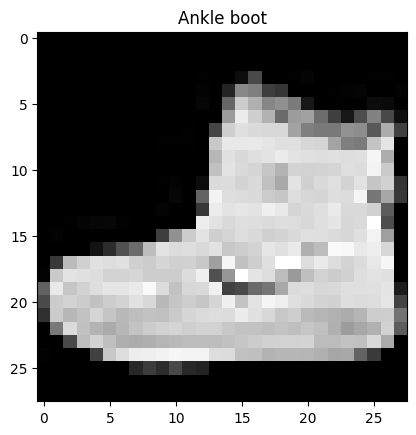

In [5]:
# Let's visualize the first sample in the train dataset:
plt.imshow(image.squeeze(), cmap = "gray")
plt.title(class_names[label])

Now, we will generates a 3x3 grid of randomly selected images from the training dataset, displaying their associated class labels.

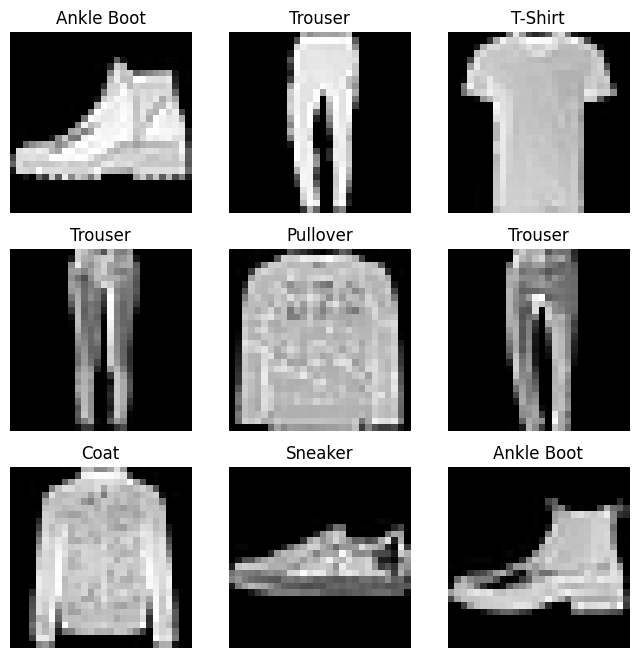

In [6]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

figure = plt.figure(figsize = (8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap = "gray")
plt.show()

## 1.3 Preparing your data with DataLoaders

Now we've got a dataset ready to go.

The next step is to prepare it with a [`torch.utils.data.DataLoader`](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) or `DataLoader` for short. The Dataset retrieves our dataset’s features and labels one sample at a time. Dataloader turns a large `Dataset` into a Python iterable of smaller chunks called **batches** or **mini-batches** that can be set by the `batch_size` hyperparameter. While training a model, we typically want to pass these batches, reshuffle the data at every epoch to reduce model overfitting, and use Python’s multiprocessing to speed up data retrieval. DataLoader is an iterable that abstracts this complexity for us in an easy API.



In [7]:
# Setup the batch size hyperparameter
BATCH_SIZE = 32

train_dataloader = DataLoader(train_data, batch_size = 32, shuffle = True)
test_dataloader = DataLoader(test_data, batch_size = 32, shuffle = False) # Shuffling the testing data is not necessarily required.

# Check the number of batches and the batch size
print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")

Length of train dataloader: 1875 batches of 32
Length of test dataloader: 313 batches of 32


The dataset has been loaded into the DataLoader, allowing us to iterate through it as necessary. In the code below, each iteration returns a batch of train_features and train_labels, where the batch size is set to 32.

In [8]:
# Check out what's inside the training dataloader
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

Feature batch shape: torch.Size([32, 1, 28, 28])
Labels batch shape: torch.Size([32])


> **Note:** The returned shape now follows the NCHW format (alternatively, you may encounter the NHWC format), where N represents the number of images or samples per batch. For instance, in this case we have a batch_size = 32, so our tensor shape is [32, 1, 28, 28].

We can check that the data remains unchanged by showing a single sample:

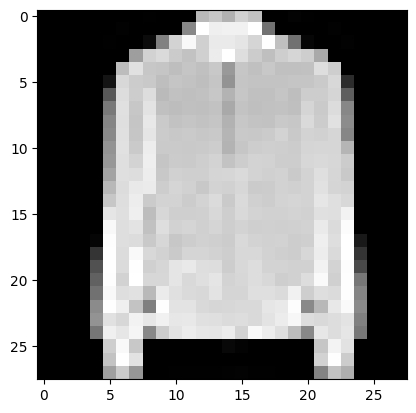

Label: 4


In [9]:
# Display image and label.
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

# Exercise 1

### CIFAR10 dataset:

A. Load CIFAR10 dataset (train and test sets). Apply transformations to convert the images to tensors and normalize them using mean = [0.5, 0.5, 0.5] and std = [0.5, 0.5, 0.5]. (Use **transform.Compose**).

B. Create the dataloaders using batchsize = 4.

C. Indicate the image shape [color_channels, height, width]. 

D. Which classes are included in the dataset?

E. Calculate the total number of samples in the CIFAR10 train and test datasets.

F. Displays 5 random images with their corresponding label. Optional:Use (seed=42) for reproducibility.

# 2. Working with our own datasets

In this section, instead of using an in-built PyTorch dataset, we're going to be using our own datasets.
Specifically, we're going to cover:

| **Topic**                                   | **Contents**                                                                                         |
| :------------------------------------------- | :----------------------------------------------------------------------- |
| **1. Get data**                             | Explore available datasets to find one suitable for your task.               |
| **2. Data analysis and preparation**         | At the beginning of any new machine learning problem, it's paramount to understand the data we're working with. |
| **3. Transforming data**                     | Here we'll look at some steps we can take to *transform* our images so they're ready to be used with a model. |
| **4. Data augmentation** | Data augmentation is a common technique for expanding the diversity of our training data. Here we'll explore some of `torchvision`'s in-built data augmentation functions. |
| **5. Loading data with `ImageFolder`** | PyTorch has many in-built data loading functions for common types of data. `ImageFolder` is helpful if our images are in standard image classification format. |
| **6. Loading image data with a custom `Dataset`** | We will build our own custom subclass of `torch.utils.data.Dataset`. |







## 2.1 Get data

We will work with 2 datasets that can be downloaded in the following links:
* [Transport dataset](https://www.kaggle.com/datasets/abtabm/multiclassimagedatasetairplanecar)
* [Wheather dataset](https://www.kaggle.com/datasets/pratik2901/multiclass-weather-dataset)

In my case, the datasets are located as follows.If you choose to modify the folder names or locations, it is important to ensure that the code is modified accordingly to reflect these adjustments.  

```
TTT-DLBootcamp/
    notebooks/ 
        02_data_preprocessing.ipynb 
    datasets/ 
        Transport_Dataset/ 
            train/ 
                airplanes/ 
                    airplane1.jpg
                    ...
                cars/
                    cars1.jpg
                    ...
                ships/
                    ships1.jpg
                    ...
            test/ 
               airplanes/ 
                    airplane1.jpg
                    ...
                cars/
                    cars1.jpg
                    ...
                ships/
                    ships1.jpg
                    ...
        Weather_Dataset/
            Sunrise/ 
                sunrise1.jpg
                ...
            Rain/ 
                rain1.jpg
                ...
            Shine/
                shine1.jpg
                ...
             Cloudy/
                 cloudy1.jpg
                ...      
```

## 2.2 Data analysis and preparation

In the upcoming steps, we will be working with the Transport dataset and offering exercises based on the Weather dataset.

First, we can inspect what's in our data directory by writing a small helper function to walk through each of the subdirectories and count the files present.

To do so, we'll use Python's in-built [`os.walk()`](https://docs.python.org/3/library/os.html#os.walk). 

In [10]:
def walk_through_dir(dir_path):
    """
    Walks through dir_path returning its contents.
    Args:
      dir_path (str or pathlib.Path): target directory
    
    Returns:
      Prints the number of images (files) in each subdirectory.
    """
    for dirpath, dirnames, filenames in os.walk(dir_path):
        if len(filenames) > 0:
            print(f"There are {len(filenames)} images in the directory '{dirpath}'.")

In [11]:
# Example usage
image_path = Path("../datasets/Transport_Dataset")
walk_through_dir(image_path)

There are 189 images in the directory '..\datasets\Transport_Dataset\test\airplanes'.
There are 193 images in the directory '..\datasets\Transport_Dataset\test\cars'.
There are 200 images in the directory '..\datasets\Transport_Dataset\test\ships'.
There are 1000 images in the directory '..\datasets\Transport_Dataset\train\airplanes'.
There are 1000 images in the directory '..\datasets\Transport_Dataset\train\cars'.
There are 1000 images in the directory '..\datasets\Transport_Dataset\train\ship'.


We've got about 1000 images per training class and 200 images per testing class.

In [12]:
# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(WindowsPath('../datasets/Transport_Dataset/train'),
 WindowsPath('../datasets/Transport_Dataset/test'))

Random image path: ..\datasets\Transport_Dataset\train\cars\cars526.jpg
Image class: cars
Image height: 1200
Image width: 1200


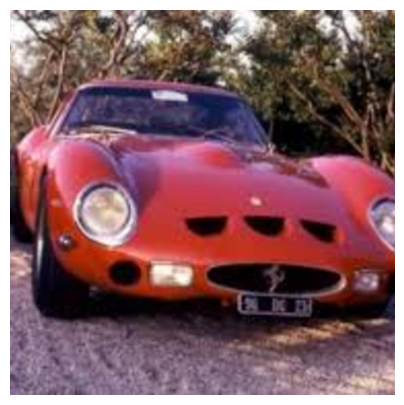

In [13]:
# Set seed
random.seed(50) # <- try changing this and see what happens

# 1. Get all image paths (* means "any combination")
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. Get random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem

# 4. Open an image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}") 
print(f"Image width: {img.width}")

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(5, 5))
plt.imshow(img_as_array)
plt.axis(False);

## 2.3 Transforming data

To work with images in PyTorch we must carry out at least 2 actions:

1. Turn them into tensors (numerical representations of our images).
2. Turn them into a Dataset and subsequently a DataLoader.

The **torchvision.transforms** module provides a powerful set of tools for preprocessing and augmenting image data before feeding it into a deep learning model. The module includes various classes and functions for different transformations, such as resizing, cropping, normalization, flipping, rotation, and more.

The module provides the **Compose** class, which allows you to chain multiple transformations together in a specific order. This enables you to define a transformation pipeline by applying a sequence of transformations to an input image.

> Check out  [this link](https://pytorch.org/vision/stable/transforms.html#transforming-and-augmenting-images) for aditional information about transforming and augmenting images in Pytorch.

### Ilustrations of some basic transforms

In [14]:
original_image = Image.open(random_image_path)

### Pad

The pad transform is used to increase the size of an image by adding pixels around its borders.

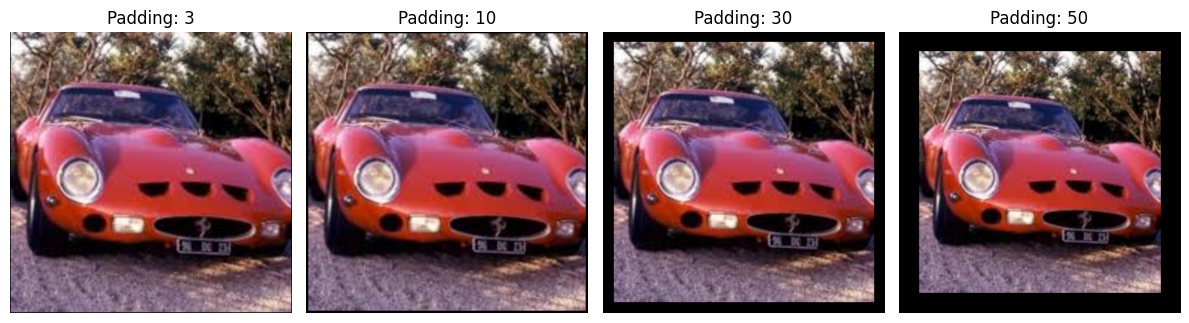

In [15]:
padded_imgs = [transforms.Pad(padding = padding)(original_image) for padding in (3, 10, 50, 100)]
fig, axes = plt.subplots(1, len(padded_imgs), figsize=(12, 6))
for ax, padded_img, padding in zip(axes, padded_imgs, (3, 10, 30, 50)):
    ax.imshow(padded_img)
    ax.set_title(f'Padding: {padding}')
    ax.axis('off')
plt.tight_layout()
plt.show()

### CenterCrop

The CenterCrop transform in PyTorch is used to extract a centered rectangular region from an input image. It crops the image while preserving its center. 

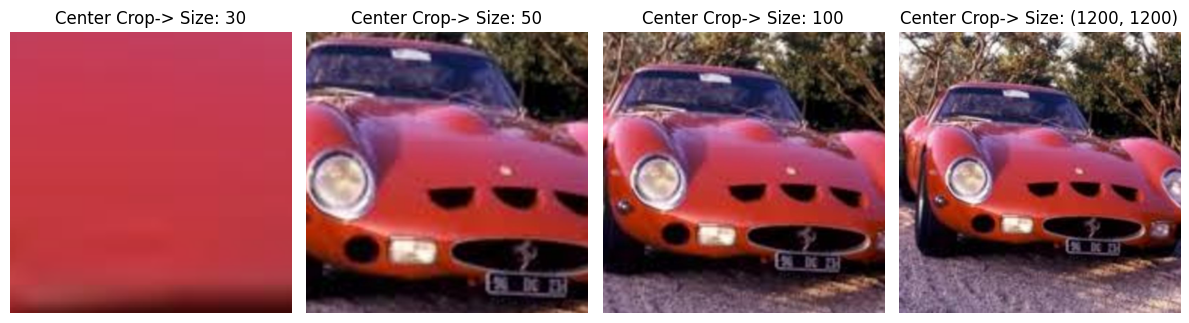

In [16]:
cropped_imgs = [transforms.CenterCrop(size = size)(original_image) for size in (100, 800, 1000, original_image.size)]
fig, axes = plt.subplots(1, len(cropped_imgs), figsize=(12, 6))
for ax, cropped_img, size in zip(axes, cropped_imgs, (30, 50, 100, original_image.size)):
    ax.imshow(cropped_img)
    ax.set_title(f'Center Crop-> Size: {size}')
    ax.axis('off')
plt.tight_layout()
plt.show()

### Resize

It allows you to change the size of an image while maintaining its aspect ratio. It can be used to both upscale or downscale the image dimensions.

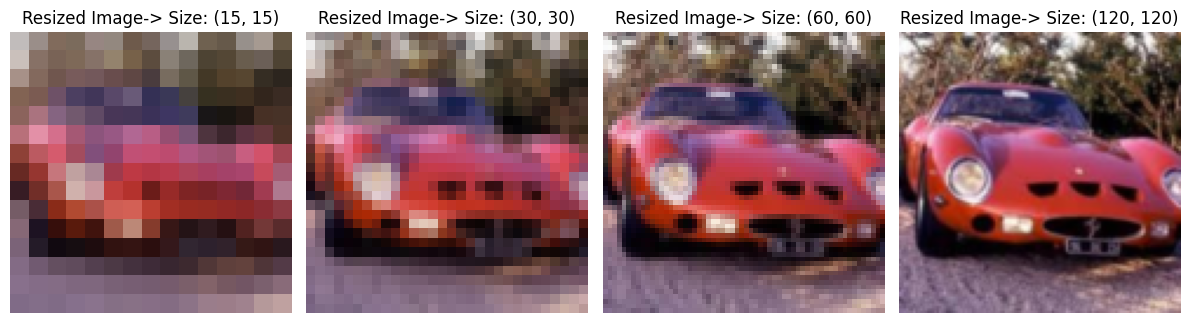

In [17]:
size = [(15, 15), (30, 30), (60, 60), (120, 120)]
resized_imgs = [transforms.Resize(size)(original_image) for size in size]
fig, axes = plt.subplots(1, len(resized_imgs), figsize=(12, 6))
for ax, resized_img, size in zip(axes, resized_imgs, size):
    ax.imshow(resized_img)
    ax.set_title(f'Resized Image-> Size: {size}')
    ax.axis('off')
plt.tight_layout()
plt.show()


### Define the transformation steps using transforms.Compose()

Now, we will define a series of image transformations using **transforms.Compose()**. These transformations include resizing, cropping and image normalization.

In [18]:
def transform_and_plot_image(image_path, data_transform):
    
    """
    Applies the given data transformation to the image and plots the original and transformed images.

    Args:
        image_path (str): Path to the image file.
        data_transform (torchvision.transforms.Compose): Data transformation to apply to the image.
    """
    
    # Load the original image
    original_image = Image.open(image_path)

    # Apply the transformation
    transformed_image = data_transform(original_image)
    
    #---------Comment this part and visualize the results------------------

    # Unnormalize the transformed image tensor to represent the images
    unnormalize = transforms.Normalize((-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225),
                                       (1 / 0.229, 1 / 0.224, 1 / 0.225))
    transformed_image = unnormalize(transformed_image)
    
    #-----------------------------------------------------------------------
    
    # Convert the transformed image tensor to a numpy array
    transformed_image_np = transformed_image.permute(1, 2, 0).numpy()
    
    # Print the original and transformed image dimensions
    print("Original Image Dimensions:", original_image.size)
    print("Transformed Image Dimensions:", transformed_image_np.shape)

    # Plot the original image
    plt.subplot(1, 2, 1)
    plt.title('Original Image')
    plt.imshow(original_image)
    plt.axis('off')

    # Plot the transformed image
    plt.subplot(1, 2, 2)
    plt.title('Transformed Image')
    plt.imshow(transformed_image_np)
    plt.axis('off')

    # Display the plot
    plt.show()

Original Image Dimensions: (1200, 1200)
Transformed Image Dimensions: (224, 224, 3)


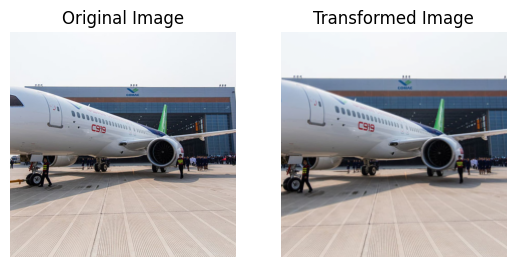

Original Image Dimensions: (1200, 1200)
Transformed Image Dimensions: (224, 224, 3)


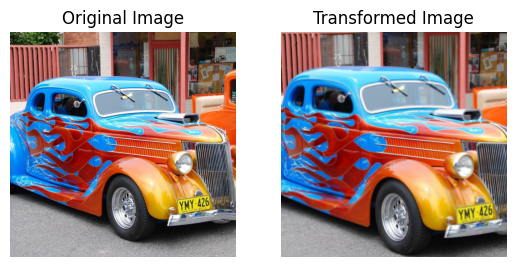

Original Image Dimensions: (210, 128)
Transformed Image Dimensions: (224, 224, 3)


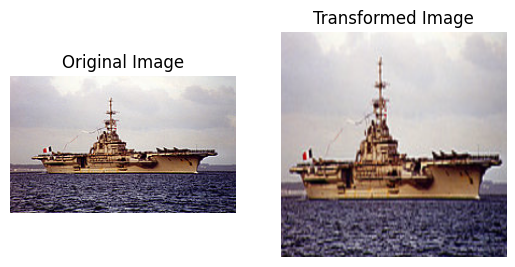

In [19]:
# Define the transformation steps using transforms.Compose()
data_transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize the image to (256, 256)
    transforms.CenterCrop(224),  # Center crop the image to (224, 224)
    transforms.ToTensor(),  # Convert the image to a tensor
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),  # Normalize the image using the statistics of ImageNet 
    ])

# Define the directory paths
directories = [str(test_dir / "airplanes"),
               str(test_dir / "cars"),
               str(test_dir / "ships")]

# Select a random image of each directory
random.seed(40) # Set the random seed
num_images = 1
selected_image_paths = []
for directory in directories:
    image_paths = [os.path.join(directory, file) for file in os.listdir(directory)]
    selected_image_paths.extend(random.sample(image_paths, num_images))

# Plot the images with their transformations
for image_path in selected_image_paths:
    transform_and_plot_image(image_path, data_transform)

> Note: If you comment out lines 17-24 in the transform_and_plot_image function to represent the images in a normalized manner, you may encounter a "Clipping input data" warning message when plotting the images. This warning suggests that the pixel values exceed the valid range of [0...1] for floats or [0...255] for integers. In this situation, the pixel values will be clipped to fit within the valid range, allowing them to be properly visualized using matplotlib.

## 2.4  Data augmentation

Data augmentation refers to the technique of manipulating data to increase the diversity within a training set artificially. By introducing various transformations, such as those provided by torchvision.transforms in PyTorch, the dataset is modified to enhance the model's ability to generalize and handle unseen examples more effectively. The goal is to expose the model to different variations of the data, enabling it to learn more robust and adaptable patterns.

In [20]:
original_image = Image.open(random_image_path)

### Random rotation

The RandomRotation transform rotates an image with random angle. In this example, the image will be rotated by a random angle selected uniformly from the range of -90 to +90 degrees.

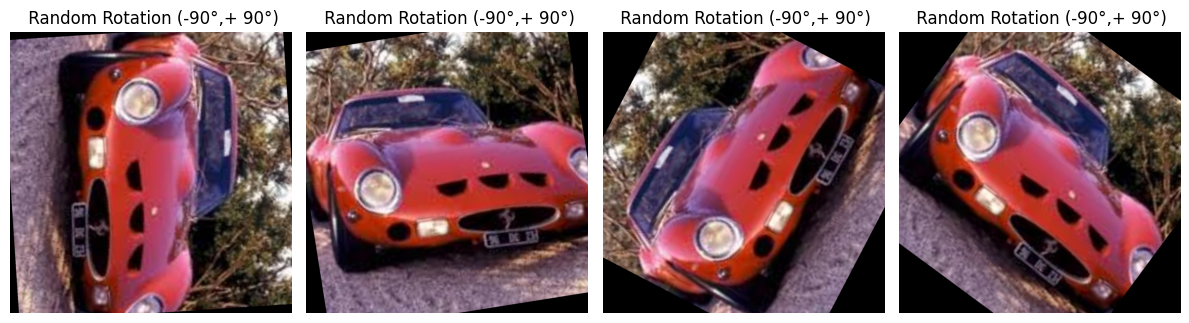

In [37]:
rotater = transforms.RandomRotation(degrees = (90))
rotated_imgs = [rotater(original_image) for _ in range(4)]

fig, axes = plt.subplots(1, len(rotated_imgs), figsize=(12, 6))
for ax, img  in zip(axes, rotated_imgs):
    ax.imshow(img)
    ax.set_title(f' Random Rotation (-90°,+ 90°)')
    ax.axis('off')
plt.tight_layout()
plt.show()

### Random horizontal flip

The RandomHorizontalFlip transform performs horizontal flip of an image, with a given probability.

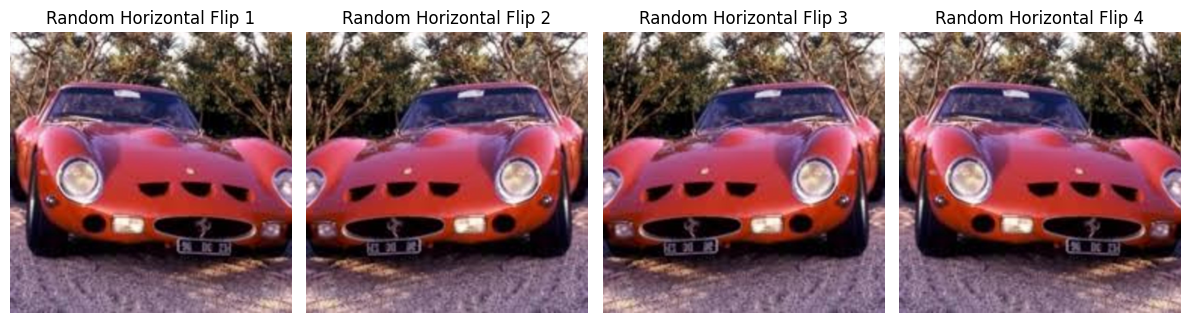

In [38]:
original_image = Image.open(random_image_path)
flipped_imgs = [transforms.RandomHorizontalFlip()(original_image) for _ in range(4)]
fig, axes = plt.subplots(1, len(flipped_imgs), figsize=(12, 6))
for ax, flipped_img, idx in zip(axes, flipped_imgs, range(4)):
    ax.imshow(flipped_img)
    ax.set_title(f'Random Horizontal Flip {idx+1}')
    ax.axis('off')
plt.tight_layout()
plt.show()

### Random ColorJitter
The ColorJitter transform randomly changes the brightness, saturation, and other properties of an image.

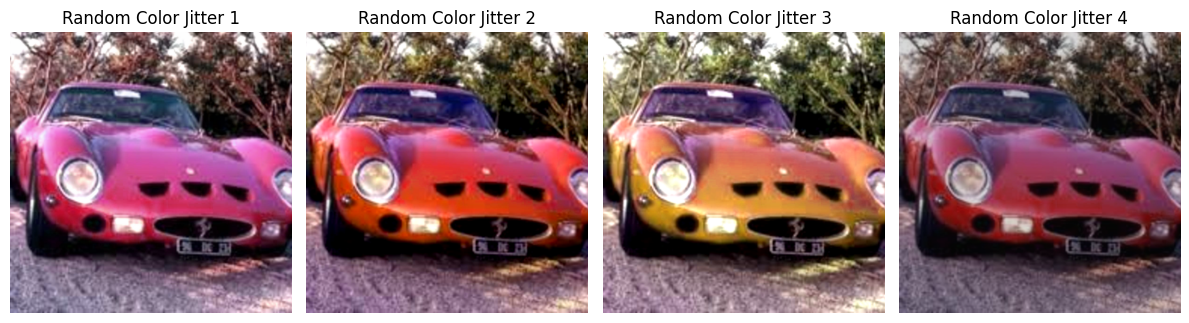

In [39]:
original_image = Image.open(random_image_path)
jittered_imgs = [transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1)(original_image) for _ in range(4)]
fig, axes = plt.subplots(1, len(jittered_imgs), figsize=(12, 6))
for ax, jittered_img, idx in zip(axes, jittered_imgs, range(4)):
    ax.imshow(jittered_img)
    ax.set_title(f'Random Color Jitter {idx+1}')
    ax.axis('off')
plt.tight_layout()
plt.show()


Now, we will define a series of image transformations using **transforms.Compose()** where we will integrate data augmentation.These transformations include random resizing and cropping, horizontal flipping, color jittering, random rotation, converting to tensor, and image normalization.

In [40]:
data_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),  # Randomly crop and resize the image
    transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
    transforms.ColorJitter(brightness = 0.4, contrast = 0.4, saturation = 0.4, hue = 0.1),  # Adjust color values
    transforms.RandomRotation(10),  # Randomly rotate the image by 10 degrees
    transforms.ToTensor(),  # Convert the image to a tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize the image
])

Original Image Dimensions: (1200, 1200)
Transformed Image Dimensions: (224, 224, 3)


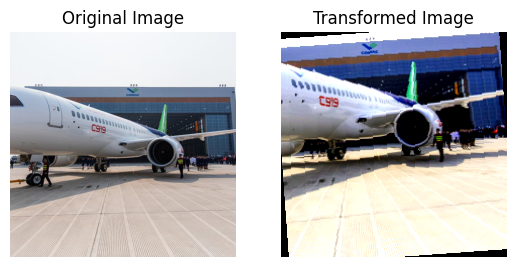

Original Image Dimensions: (1200, 1200)
Transformed Image Dimensions: (224, 224, 3)


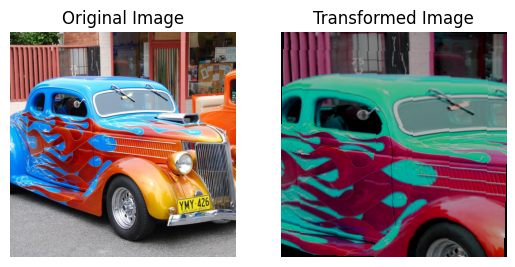

Original Image Dimensions: (210, 128)
Transformed Image Dimensions: (224, 224, 3)


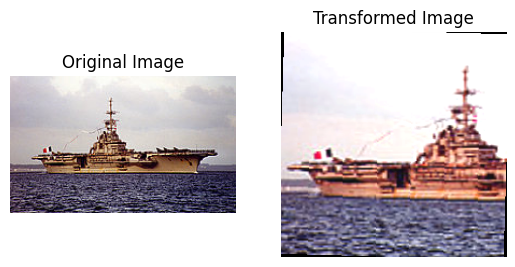

In [45]:
# Plot the images with their transformations
for image_path in selected_image_paths:
    transform_and_plot_image(image_path, data_transform)

### 2.5  Loading data with ImageFolder

Given that our data adheres to the standard image classification format, we have the option to utilize the [`torchvision.datasets.ImageFolder`](https://pytorch.org/vision/stable/generated/torchvision.datasets.ImageFolder.html#torchvision.datasets.ImageFolder) class. This class allows us to specify the file path of the desired image directory, along with a set of transformations to be applied to our images.

In [47]:
# Define the train and test data transform 
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224), # Crop a random portion of image and resize it to 224x224
    transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
    transforms.RandomEqualize(), # Randomly equalize the image 
    transforms.ToTensor(),  # Convert the image to a tensor
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize the image pixel values
])
 
test_transform = transforms.Compose([
    transforms.Resize((256)),  # Resize the image to 256x256 pixels
    transforms.CenterCrop(224), # Crop the image to 224x224 pixels
    transforms.ToTensor(),  # Convert the image to a tensor
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize the image pixel values
])

# Use ImageFolder to create dataset(s)
train_data = datasets.ImageFolder(
    root = train_dir,  # Target folder of images
    transform = train_transform  # Transforms to perform on train data (images)
)

test_data = datasets.ImageFolder(
    root = test_dir,
    transform = test_transform  # Transforms to perform on test data (images)
)

To examine our datasets, we can inspect the classes and class_to_idx attributes, along with the lengths of our training and test sets.

In [48]:
# Get class names as a list
class_names = train_data.classes
print("Class names (list):", class_names)

# Get class names as a dictionary
class_dict = train_data.class_to_idx
print("Class names (dictionary):", class_dict)

# Check the lengths
print("Length of train_data:", len(train_data))
print("Length of test_data:", len(test_data))

Class names (list): ['airplanes', 'cars', 'ship']
Class names (dictionary): {'airplanes': 0, 'cars': 1, 'ship': 2}
Length of train_data: 3000
Length of test_data: 582


We've got our images as PyTorch Dataset's but now let's turn them into DataLoader's.

In [49]:
train_dataloader = DataLoader(dataset = train_data, 
                              batch_size = 8, # Samples per batch
                              num_workers = 1, # Number of subprocesses to use for data loading
                              shuffle = True) # We usually shuffle training data

test_dataloader = DataLoader(dataset = test_data, 
                             batch_size = 8, 
                             num_workers = 1, 
                             shuffle = False) # Don't usually need to shuffle testing data

In [50]:
img, label = next(iter(train_dataloader))

# Check the shapes:
print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

# The batch size is now 8. Try changing the 'batch_size' parameter above and observe how it modifies the image shape

Image shape: torch.Size([8, 3, 224, 224]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([8])


### Visualize sample data

As we did with the FashionMNIST dataset, we will retrieve a batch of images from the training dataloader and plot a subset of these images using matplotlib. To plot an image tensor using matplotlib, we need to permute (rearrange the order of its dimensions) to make it compatible. Currently, our image dimensions are in the format CHW (color channels, height, width), but matplotlib prefers HWC (height, width, color channels).

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


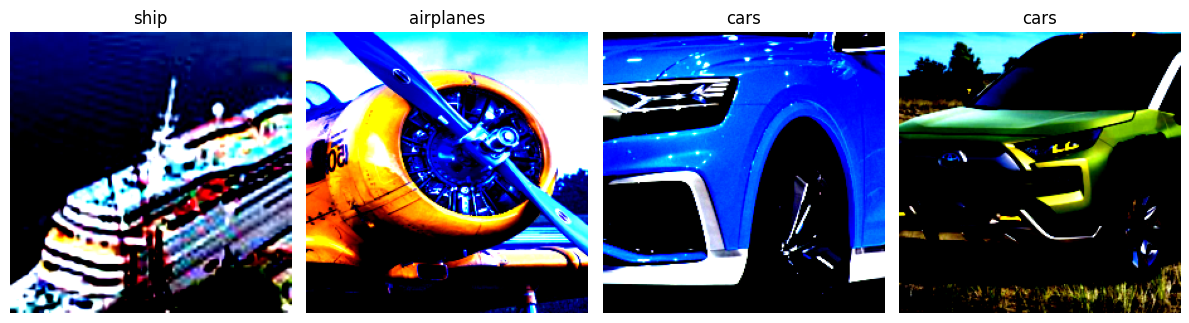

In [54]:
# Get a batch of images from the training dataloader
train_batch = next(iter(train_dataloader))
train_images, train_labels = train_batch

# Plot some of the images from the training dataset
fig, axes = plt.subplots(1, 4, figsize=(12, 6))
for i in range(4):
    img = train_images[i]
    img = img.permute(1, 2, 0)  # Reshape tensor from (C, H, W) to (H, W, C)
    class_index = train_labels[i].item()
    class_name = class_names[class_index]
    axes[i].imshow(img)
    axes[i].axis('off')
    axes[i].set_title(class_name)

plt.tight_layout()
plt.show()

### 2.6 Load image data with a custom Dataset

Now we're ready to build our own custom Dataset that replicates the functionality of torchvision.datasets.ImageFolder().
The basic steps implemented in this case are the following: 
1. Subclass torch.utils.data.Dataset.
2. Define the **`__init__()`** method to initialize the class given a data directory and an optional transform parameter and create class attributes: 
- paths: A list of image paths obtained from the specified data_dir.
- transform: Stores the provided transformation function.
- classes: Contains the sorted names of classes found in the dataset.
- class_to_idx: Maps each class name to a unique index.
4. Implement the load_image method to open and return an image based on its path.
5. Override the **`__len__()`** method to return the total number of samples in the dataset.
6. Override the **`__getitem__()`** method to retrieve a single data sample and its label

In [55]:
class CustomDataset(Dataset):
    
    def __init__(self, data_dir: str, transform = None) -> None:
        # Get all image paths
        self.paths = list(pathlib.Path(data_dir).glob("*/*.jpg")) + list(pathlib.Path(data_dir).glob("*/*.jpeg"))

        # Setup transforms
        self.transform = transform
        
        # Create classes and class_to_idx attributes
        self.classes = sorted(entry.name for entry in os.scandir(data_dir) if entry.is_dir())
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}

    def load_image(self, index: int) -> Image.Image:
        "Opens an image via a path and returns it."
        image_path = self.paths[index]
        return Image.open(image_path).convert('RGB')
    
    def __len__(self) -> int:
        "Returns the total number of samples."
        return len(self.paths)
    
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        "Returns one sample of data, data and label (X, y)."
        img = self.load_image(index)
        class_name  = self.paths[index].parent.name # expects path in data_folder/class_name/image
        class_idx = self.class_to_idx[class_name]

        # Transform if necessary
        if self.transform:
            return self.transform(img), class_idx # return data, label (X, y)
        else:
            return img, class_idx # return data, label (X, y)

In [56]:
# Define the train and test data transform 
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224), # Crop a random portion of image and resize it to 224x224
    transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
    transforms.RandomEqualize(), # Randomly equalize the image 
    transforms.ToTensor(),  # Convert the image to a tensor
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize the image pixel values
])
 
test_transform = transforms.Compose([
    transforms.Resize((256)),  # Resize the image to 256x256 pixels
    transforms.CenterCrop(224), # Crop the image to 224x224 pixels
    transforms.ToTensor(),  # Convert the image to a tensor
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize the image pixel values
])

# Use Iour CustomDataset class to create dataset(s)
train_custom_data = CustomDataset(data_dir = train_dir, 
                                  transform = train_transform)

test_custom_data = CustomDataset(data_dir = test_dir, 
                                 transform = test_transform)

After defining the dataset, we can continue working in the same manner as before. This includes creating a dataloader, iterating over the data, displaying random samples, and checking the dimensions of the data, just as we did previously

In [57]:
# Get class names as a list
class_names = train_data.classes
print("Class names (list):", class_names)

# Get class names as a dictionary
class_dict = train_data.class_to_idx
print("Class names (dictionary):", class_dict)

# Check the lengths
print("Length of train_data:", len(train_data))
print("Length of test_data:", len(test_data))

Class names (list): ['airplanes', 'cars', 'ship']
Class names (dictionary): {'airplanes': 0, 'cars': 1, 'ship': 2}
Length of train_data: 3000
Length of test_data: 582


In [58]:
# Turn train and test custom Dataset's into DataLoader's
train_custom_dataloader = DataLoader(dataset = train_custom_data, 
                                     batch_size = 8, 
                                     num_workers = 0, 
                                     shuffle = True) 

test_custom_dataloader = DataLoader(dataset = test_custom_data, 
                                    batch_size = 8, 
                                    num_workers = 0, 
                                    shuffle = False) 

In [59]:
# Retrieve a single batch of data and its corresponding labels from the train dataset
img, label = next(iter(train_custom_dataloader))

# Check the shapes:
print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([8, 3, 224, 224]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([8])


# Exercise 2
### Weather dataset:

Before we begin working with the Weather dataset, we will split the files into training, test, and validation sets. There are various approaches to accomplish this task. In our case, we will create a new directory called "Weather_Split_Dataset," which will be further divided into three sets (training, validation, and test), with each set having separate folders representing their respective classes. Run the following code to obtain the dataset in the desired format:

In [65]:
# Define the data directory
data_dir = '../datasets/Weather_Dataset'
output_dir = '../datasets/Weather_Dataset_Split'

# Define the categories
categories = ['Shine', 'Cloudy', 'Rain', 'Sunrise']

# Create output directories
os.makedirs(output_dir, exist_ok = True)
for split in ['train', 'test', 'val']:
    for category in categories:
        os.makedirs(os.path.join(output_dir, split, category), exist_ok = True)

# Iterate over the categories
for category in categories:
    category_dir = os.path.join(data_dir, category)

    # Get the filenames for the current category
    filenames = os.listdir(category_dir)
    random.shuffle(filenames)

    # Split the filenames into train, test, and validation sets
    train_set_filenames, test_filenames = train_test_split(filenames, test_size = 0.15, random_state = 42)
    train_filenames, val_filenames = train_test_split(train_set_filenames, test_size = 0.15, random_state = 42)

    # Move the files to the respective output directories
    for filename in train_filenames:
        src = os.path.join(category_dir, filename)
        dst = os.path.join(output_dir, 'train', category, filename)
        shutil.copy(src, dst)

    for filename in test_filenames:
        src = os.path.join(category_dir, filename)
        dst = os.path.join(output_dir, 'test', category, filename)
        shutil.copy(src, dst)

    for filename in val_filenames:
        src = os.path.join(category_dir, filename)
        dst = os.path.join(output_dir, 'val', category, filename)
        shutil.copy(src, dst)

You should now see that a new folder has been created with the following structure:

```
TTT-DLBootcamp/
    notebooks/ 
        02_data_preprocessing.ipynb 
    datasets/ 
        Weather_Dataset_Split/ 
            train/ 
                Cloudy/ 
                    cloudy1.jpg
                    ...
                Rain/
                    rain5.jpg
                    ...
                Shine/
                    shine7.jpg
                    ...
                Sunrise/
                    sunrise34.jpg
                
            test/ 
                Cloudy/ 
                    cloudy54.jpg
                    ...
                Rain/
                    rain23.jpg
                    ...
                Shine/
                    shine12.jpg
                    ...
                Sunrise/
                    sunrise33.jpg 
                    
             val/ 
                Cloudy/ 
                    cloudy3.jpg
                    ...
                Rain/
                    rain4.jpg
                    ...
                Shine/
                    shine76.jpg
                    ...
                Sunrise/
                    sunrise20.jpg
```

The most crucial lines in the code presented are as follows:

> train_set_filenames, test_filenames = train_test_split(filenames, test_size = 0.15, random_state = 42)
> train_filenames, val_filenames = train_test_split(train_set_filenames, test_size = 0.15, random_state = 42)
    
This part divides the files into training, test, and validation sets. This is achieved using the **`train_test_split`** function, which is crucial for this task. The function takes in the following parameters:

- **`filenames`**: The list of filenames or data to be split.
- **`test_size`**: This parameter determines the proportion of data allocated for the testing set.
- **`random_state`**: This optional parameter ensures reproducibility by setting a specific value. Here, we use random_state = 42 to obtain consistent splits.

First, the train_test_split function is used to split the original filenames into two subsets: train_set_filenames and test_filenames. Specifically, 15% of the total data is assigned for testing.

Following this initial split, the focus shifts to the remaining portion, represented by train_set_filenames. This subset, which accounts for 85% of the total data, is further divided into two subsets: train_filenames for training and val_filenames for validation. Within the train_set data, 15% is allocated for validation purposes.

Answer the following questions:

A. Define the transformations for the training, testing, and validation datasets separately. It's important to note that data augmentation should only be applied to the training data. The same transformation should be used for both the test and validation datasets. At the minimum, all images should be resized to the same dimensions and normalized. For data augmentation, it is recommended to apply random rotation, equalization, and a ResizedCrop transformation.

B. Create the datasets (you can use the ImageFolder class) and dataloaders. Obtain relevant information such as the sizes of the different datasets or the number of classes.

C. Visualize a few images with their corresponding labels.